# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [2]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [3]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [4]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('CLAUDE_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
openai = OpenAI()

In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [9]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [10]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [11]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nBose SoundLink Bluetooth Mobile Speaker II\nEnjoy your music on the go with this Bose SoundLink wireless mobile speaker that features Bluetooth technology for an easy connection to compatible devices. The integrated bifold cover unfolds into a stand to enable versatile placement. This refurbished product is tested and certified to look and work like new. The refurbishing process includes functionality testing, basic cleaning, inspection, and repackaging. The product ships with all relevant accessories, and may arrive in a generic box Dimensions 13.3 x 7.5 x 5.5 inches, Weight 4.44 pounds, model number Batteries 1 Lithium Ion batteries required., Rank Electronics 55339, Portable Bluetooth Speakers 1594, Is Discontinued No, Available July 23, 2014, Manufacturer'},
 {'role': 'assistant', 'content': 'Price is $158.00'}]

In [12]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [13]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nBose SoundLink Bluetooth Mobile Speaker II\nEnjoy your music on the go with this Bose SoundLink wireless mobile speaker that features Bluetooth technology for an easy connection to compatible devices. The integrated bifold cover unfolds into a stand to enable versatile placement. This refurbished product is tested and certified to look and work like new. The refurbishing process includes functionality testing, basic cleaning, inspection, and repackaging. The product ships with all relevant accessories, and may arrive in a generic box Dimensions 13.3 x 7.5 x 5.5 inches, Weight 4.44 pounds, model number Batteries 1 Lithium Ion batteries required., Rank Electronics 55339, Portable Bluetooth Speakers 1594, Is Discontinued No, Available July 23, 2014, Manufacturer"}, {"role": "assistant", "content": "Price is $158.00

In [14]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [15]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [16]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [17]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [18]:
train_file

FileObject(id='file-BKKgG7ZA3i75q1vVettcKA', bytes=186933, created_at=1735512230, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [19]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [20]:
validation_file

FileObject(id='file-HCCKXRRcjPBF35tFg46SGD', bytes=46786, created_at=1735512235, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

# Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [23]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [22]:
train_file.id

'file-BKKgG7ZA3i75q1vVettcKA'

In [24]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-e10RDwgHL7AkC8iEO9bcAM2c', created_at=1735512572, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-m7K1ZpWIMZKmaGUWQXj977ng', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-BKKgG7ZA3i75q1vVettcKA', validation_file='file-HCCKXRRcjPBF35tFg46SGD', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-e10RDwgHL7AkC8iEO9bcAM2c'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [25]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-e10RDwgHL7AkC8iEO9bcAM2c', created_at=1735512572, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-m7K1ZpWIMZKmaGUWQXj977ng', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-BKKgG7ZA3i75q1vVettcKA', validation_file='file-HCCKXRRcjPBF35tFg46SGD', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-e10RDwgHL7AkC8iEO9bcAM2c'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix

In [26]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [27]:
job_id

'ftjob-e10RDwgHL7AkC8iEO9bcAM2c'

In [28]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-e10RDwgHL7AkC8iEO9bcAM2c', created_at=1735512572, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-m7K1ZpWIMZKmaGUWQXj977ng', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-BKKgG7ZA3i75q1vVettcKA', validation_file='file-HCCKXRRcjPBF35tFg46SGD', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-e10RDwgHL7AkC8iEO9bcAM2c'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [39]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-5rFkAROtV8C8eP3Fn0JwwvQb', created_at=1735513172, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-vq6g0x1AgiiqjvNf9sgghD8O', created_at=1735513107, level='info', message='Step 200/200: training loss=1.33, validation loss=1.55, full validation loss=0.87', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.3336222171783447, 'valid_loss': 1.5492479801177979, 'total_steps': 200, 'full_valid_loss': 0.874340443611145, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.805}, type='metrics'),
 FineTuningJobEvent(id='ftevent-KzzAXfsgnItmxkrayPMYxqHb', created_at=1735513100, level='info', message='Step 199/200: training loss=0.60', object='fine_tuning.job.event', data={'step': 199, 'train_loss': 0.5983221530914307, 'total_steps': 200, 'train_mean_token_accuracy': 0.875}, type='metrics'),
 FineTuningJ

# Step 3

Test our fine tuned model

In [40]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [41]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal-openai-organization:pricer:AjwXrHNr'

In [42]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [43]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nHabisder 2022 Laptops 14.1'' Laptop Computer, 8GB RAM 128GB SSD, Windows 10 Laptop, Celeron J3455 Processor, IPS Display, Ultra Slim Notebook PC, WiFi,\nColor Silver SSD Material plastic paint Screen type 14.1 inch IPS screen Screen resolution 1366 * 768 IPS CPU quad-core Graphics card HD set display CPU frequency quad-core 1.5GHz up to 2.3Ghz Operating system for Windows 10 64-bit Memory LPDDR3 8GB Hard disk 128GB SSD Can be expanded to 1TB SSD Built in wireless LAN Wireless standard / b / g / n / ac) Built-in sound chip Built in speaker Built in microphone Graphics card integrated graphics Input device touchpad"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [44]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [45]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [46]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [47]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

138.0
393.69


In [48]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Habisder 2022 Laptops 14.1'' Laptop Computer, 8GB RAM 128GB SSD, Windows 10 Laptop, Celeron J3455 Processor, IPS Display, Ultra Slim Notebook PC, WiFi,
Color Silver SSD Material plastic paint Screen type 14.1 inch IPS screen Screen resolution 1366 * 768 IPS CPU quad-core Graphics card HD set display CPU frequency quad-core 1.5GHz up to 2.3Ghz Operating system for Windows 10 64-bit Memory LPDDR3 8GB Hard disk 128GB SSD Can be expanded to 1TB SSD Built in wireless LAN Wireless standard / b / g / n / ac) Built-in sound chip Built in speaker Built in microphone Graphics card integrated graphics Input device touchpad

Price is $


1: Guess: $393.69 Truth: $138.00 Error: $255.69 SLE: 1.09 Item: Habisder 2022 Laptops 14.1'' Laptop Comp...
2: Guess: $127.99 Truth: $399.99 Error: $272.00 SLE: 1.29 Item: 10" 1080P Backup Camera Monitor & Built-...
3: Guess: $127.99 Truth: $149.99 Error: $22.00 SLE: 0.02 Item: Avolusion PRO-5X Series 12TB USB 3.0 Ext...
4: Guess: $22.22 Truth: $73.05 Error: $50.83 SLE: 1.34 Item: LG EBF61215202 Genuine OEM Lid Switch As...
5: Guess: $1.65 Truth: $68.97 Error: $67.32 SLE: 10.72 Item: LG EBF62174902 LG-EBF62174902 Switch,Rot...
6: Guess: $899.00 Truth: $839.00 Error: $60.00 SLE: 0.00 Item: CyberpowerPC Gamer Master Gaming PC, AMD...
7: Guess: $47.99 Truth: $80.99 Error: $33.00 SLE: 0.27 Item: Herdio 5.25 Inch Wall Mount Passive Spea...
8: Guess: $8.99 Truth: $18.98 Error: $9.99 SLE: 0.48 Item: FitTurn Compatible with SKG V7 V7 Pro Ba...
9: Guess: $22.99 Truth: $23.99 Error: $1.00 SLE: 0.00 Item: TRUMiRR Watch Band for Fenix 7 Sapphire ...
10: Guess: $22.99 Truth: $78.99 Error: $56.00 SL

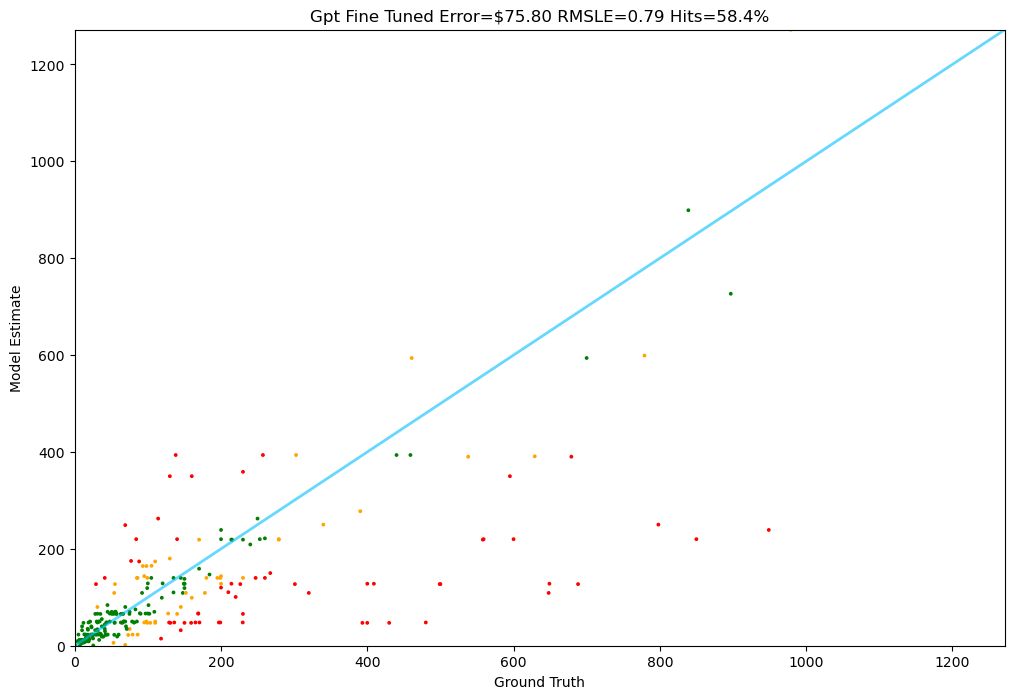

In [49]:
Tester.test(gpt_fine_tuned, test)